# Trabalho Computacional 2. Perceptron Multicamada no problema MNIST
Rodrigo Fonseca Torreão
211066196
## 1. Introdução e Preparação

In [53]:
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [34]:
class MNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = ""
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

In [3]:
dataset = MNIST()

In [4]:
@d2l.add_to_class(MNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

def evaluate_accuracy(model, data_iter):
	model.eval()
	metric = d2l.Accumulator(2)
	with torch.no_grad():		
		for X, y in data_iter:
			metric.add(d2l.accuracy(model(X), y), y.numel())
	model.train()
	return metric[0] / metric[1]

## 2. Modelos e Arquiteturas
### 2a) Perceptron com uma camada escondida, função de ativação sigmoide e otimização por descida de gradiente.


In [5]:
class MLP_1(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.Sigmoid(), nn.LazyLinear(num_outputs))

Final validation accuracy:  0.9441


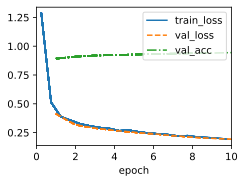

In [7]:
model = MLP_1(num_outputs=10, num_hiddens=128, lr=0.1)
data = dataset
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))

In [12]:
X, y = next(iter(dataset.val_dataloader()))
preds = torch.argmax(model(X), axis=1)

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
         4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
         4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3]))

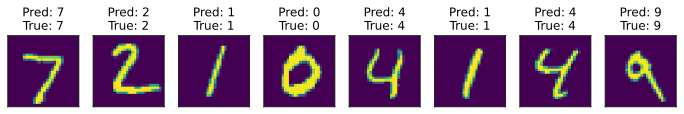

In [13]:
wrong = preds == y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds, y)]

data.visualize([X, y], labels=labels)

### 2b) Otimizador Adam

In [14]:
class MLP_Adam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.Sigmoid(), nn.LazyLinear(num_outputs))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


Final validation accuracy:  0.9246


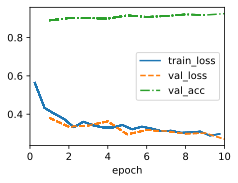

In [17]:
model_Adam = MLP_Adam(num_outputs=10, num_hiddens=128, lr=0.1)
trainer_Adam = d2l.Trainer(max_epochs=10)
trainer_Adam.fit(model_Adam, data)
print('Final validation accuracy: ', evaluate_accuracy(model_Adam, data.val_dataloader()))

### 2c) Otimizador ReLU


In [16]:
class MLP_ReLU(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


Final validation accuracy:  0.8963


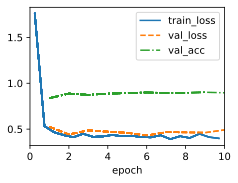

In [20]:
model_ReLU = MLP_ReLU(num_outputs=10, num_hiddens=128, lr=0.1)
trainer_ReLU = d2l.Trainer(max_epochs=10)
trainer_ReLU.fit(model_ReLU, data)
print('Final validation accuracy: ', evaluate_accuracy(model_ReLU, data.val_dataloader()))

### 2d) Otimizador ReLU

In [22]:
class MLP_256(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Final validation accuracy:  0.8963


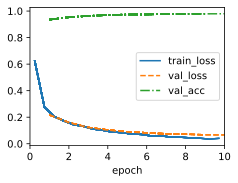

In [24]:
model_256 = MLP_256(num_outputs=10, num_hiddens=256, lr=0.001)
trainer = d2l.Trainer(max_epochs=10)

trainer.fit(model_256, data)
print('Final validation accuracy: ', evaluate_accuracy(model_ReLU, data.val_dataloader()))

In [25]:
class MLP_2Layers(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens1=128, num_hiddens2=64, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, num_hiddens1),
            nn.ReLU(),
            nn.Linear(num_hiddens1, num_hiddens2),
            nn.ReLU(),
            nn.Linear(num_hiddens2, num_outputs)
        )
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)

Acurácia (2 camadas: 128→64): 97.51%


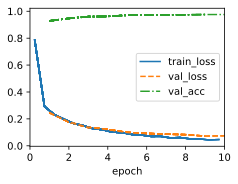

In [26]:
model_2layers = MLP_2Layers(num_hiddens1=128, num_hiddens2=64, lr=0.001)
trainer = d2l.Trainer(max_epochs=10)

trainer.fit(model_2layers, data)

val_acc_2layers = evaluate_accuracy(model_2layers, data.val_dataloader())
print(f"Acurácia (2 camadas: 128→64): {val_acc_2layers:.2%}")

## 3. Vizualização

Erros do MLP Inicial:


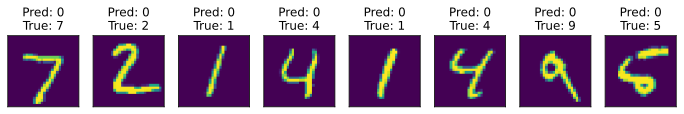

In [30]:
X_val, y_val = next(iter(dataset.val_dataloader()))
model.eval()
with torch.no_grad():
    preds_1 = torch.argmax(model(X_val), axis=1)

wrong_1 = preds_1 != y_val
X_wrong_1, y_wrong_1, preds_wrong_1= X_val[wrong_1], y_val[wrong_1], preds_1[wrong_1]

labels_1 = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_1, y_wrong_1)]

print("Erros do MLP Inicial:")
dataset.visualize([X_wrong_1[:8], y_wrong_1[:8]], labels=labels_1[:8], nrows=1, ncols=8)


Erros do MLP (Adam + Sigmoid):


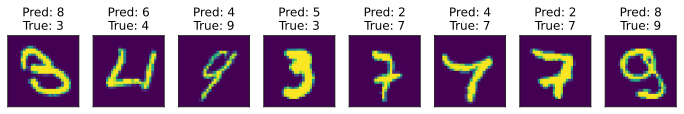

In [39]:
model_Adam.eval()
with torch.no_grad():
    preds_adam = torch.argmax(model_Adam(X_val), axis=1)
    
wrong_adam = preds_adam != y_val
X_wrong_adam, y_wrong_adam, preds_wrong_adam = X_val[wrong_adam], y_val[wrong_adam], preds_adam[wrong_adam]

# Gera rótulos
labels_adam = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_adam, y_wrong_adam)]

# Visualiza (máx. 8 imagens)
print("Erros do MLP (Adam + Sigmoid):")
data.visualize([X_wrong_adam[:8], y_wrong_adam[:8]], labels=labels_adam[:8], nrows=1, ncols=8)

Erros do MLP (ReLU):


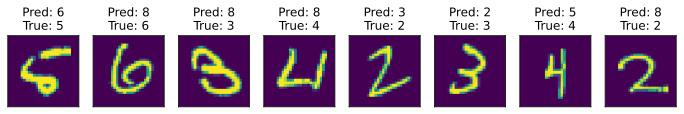

In [41]:
model_ReLU.eval()
with torch.no_grad():
    preds_relu = torch.argmax(model_ReLU(X_val), axis=1)

wrong_relu = preds_relu != y_val
X_wrong_relu, y_wrong_relu, preds_wrong_relu = X_val[wrong_relu], y_val[wrong_relu], preds_relu[wrong_relu]

labels_relu = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_relu, y_wrong_relu)]

print("Erros do MLP (ReLU):")
data.visualize([X_wrong_relu[:8], y_wrong_relu[:8]], labels=labels_relu[:8], nrows=1, ncols=8)

Erros do MLP (256 neurônios):


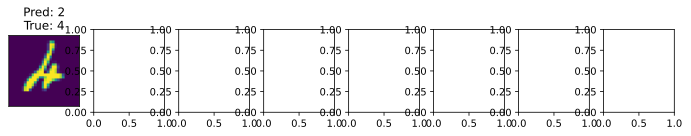

In [51]:
model_256.eval()
with torch.no_grad():
    preds_256 = torch.argmax(model_256(X_val), axis=1)

wrong_256 = preds_256 != y_val
X_wrong_256, y_wrong_256, preds_wrong_256 = X_val[wrong_256], y_val[wrong_256], preds_256[wrong_256]

labels_256 = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_256, y_wrong_256)]

print("Erros do MLP (256 neurônios):")
dataset.visualize([X_wrong_256[:8], y_wrong_256[:8]], labels=labels_256[:8], nrows=1, ncols=8)

Erros do MLP (2 camadas - 128→64):


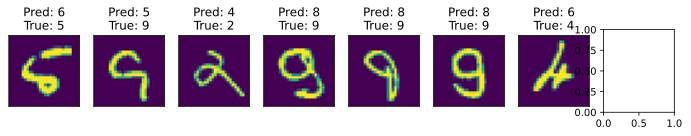

In [50]:
model_2layers.eval()
with torch.no_grad():
    preds_2l = torch.argmax(model_2layers(X_val), axis=1)

# Filtra erros
wrong_2l = preds_2l != y_val
X_wrong_2l, y_wrong_2l, preds_wrong_2l = X_val[wrong_2l], y_val[wrong_2l], preds_2l[wrong_2l]

# Gera rótulos
labels_2l = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_2l, y_wrong_2l)]

# Visualiza comparação
print("Erros do MLP (2 camadas - 128→64):")
dataset.visualize([X_wrong_2l[:8], y_wrong_2l[:8]], labels=labels_2l[:8], nrows=1, ncols=8)

## 4. Matriz de Confusão